In [1]:
import os
import pickle
import matplotlib.pyplot as plt
import numpy as np

In [2]:
data_path_taker = 'output_data/btes_base_case_orca_price_taker/btes_output_price_taker_base_BTES_discharger_#COST.pickle'
data_path_maker = 'output_data/btes_base_case_orca/btes_output_BTES_discharger_#COST.pickle'
prices = ['150','250']
colors = {'price_taker': 'r', 'price_maker': 'b'}
hatching = ['oo', '//', '++']

In [3]:
def get_btes_investment(component_results):
    """
    Get capital expenditure for BTES, i.e. sum of discharge, charge and energy store investment
    """
    btes_investment = 0
    for comp in [('Link','BTES_charger'), ('Link','BTES_discharger'), ('Store','granite')]:
        btes_investment += component_results[component_results.index == comp]['Capital Expenditure [$]'].values[0]
    return btes_investment

In [4]:
def read_output_file(filename):
    """
    Read file results
    """
    with open(filename, 'rb') as f:
        data = pickle.load(f)

        # Get cost from file name
        btes_cost = (filename.split('_')[-1].split('.')[0])

        # Get results from file
        case_data = data['case results']
        comp_results = data['component results']
        time_results = data['time results']

        return case_data, comp_results, time_results, btes_cost
    

In [5]:
def plot_bars_maker_taker(x,y, xlabel, ylabel, title=None):
    """
    Plot bar chart for price maker and price taker
    """
    plt.figure()
    # Convert x values to str
    x_ticks = np.arange(len(x))
    multiplier = 0
    width =  0.25
    for run,cost in y.items():
        print(run)
        print(cost)
        offset = width * (multiplier+0.5)
        if not isinstance(cost[0], list):
            plt.bar(x_ticks+offset, cost, color=colors[run], width=width, label=run)
        else:
            for vals in cost:
                print(vals)
                bottom = 0
                for j,nums in enumerate(vals):
                    print(nums/sum(vals))
                    plt.bar(x_ticks+offset, nums/sum(vals), width=width, label=run, bottom=bottom, 
                            color=colors[run], hatch=hatching[j])
                    bottom += nums/sum(vals)
        multiplier += 1
    # Dashed horzontal line at 0
    plt.axhline(0, color='black', linestyle='--')
    plt.xlabel(xlabel)
    plt.xticks(x_ticks+width, x)
    plt.ylabel(ylabel)
    plt.title(title if title else '')
    # Get unique legend entries
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())

In [6]:
def plot_curve_maker_taker(var, run, xlabel, ylabel, title=None):
    """
    Plot curve for price maker and price taker
    """
    plt.plot(var, color=colors[run.replace('_'+run.split('_')[-1], '')], label=run)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title if title else '')
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())

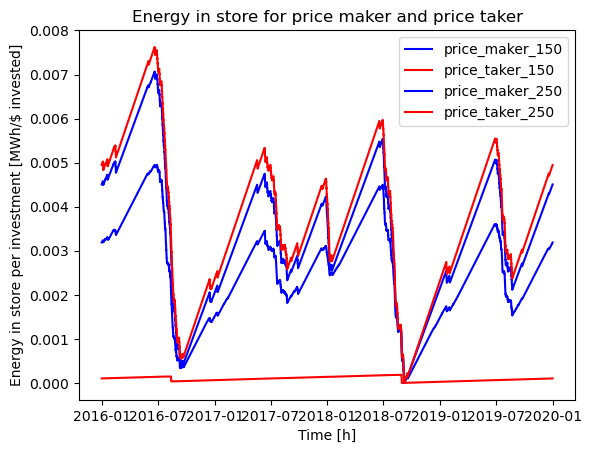

In [7]:
# Collect results
rev_per_inv = {'price_maker': [], 'price_taker': []}
duration = {'price_maker': [], 'price_taker': []}
inv = {'price_maker': [], 'price_taker': []}
energy_in_store = {'price_maker': [], 'price_taker': []}
# Loop over prices in descending order
for price in prices:
    # Get results
    for run in ['maker', 'taker']:
        case_res, comp_res, time_res, btes_cost = read_output_file(data_path_maker.replace('#COST', str(price)) if run == 'maker' else data_path_taker.replace('#COST', str(price)))

        # Calculate revenue per investment
        btes_investment = get_btes_investment(comp_res)
        hours = len(time_res)
        if run =='maker':
            cost = comp_res[comp_res.index == ('Link', 'BTES_discharger')]['Revenue [$]'].values[0] + comp_res[comp_res.index == ('Link', 'BTES_charger')]['Revenue [$]'].values[0] + comp_res[comp_res.index == ('Store', 'granite')]['Revenue [$]'].values[0]
        else:
            cost = case_res['objective [$]'].values[-1]
        cost = cost / btes_investment / hours
        rev_per_inv['price_maker' if run == 'maker' else 'price_taker'].append(cost)

        # Calculate duration
        granite = comp_res[comp_res.index == ('Store', 'granite')]
        discharger = comp_res[comp_res.index == ('Link', 'BTES_discharger')]
        charger = comp_res[comp_res.index == ('Link', 'BTES_charger')]

        granite_opt_cap = granite['Optimal Capacity [MW]'].values[0]
        discharger_opt_cap = discharger['Optimal Capacity [MW]'].values[0] 
        dur = granite_opt_cap / discharger_opt_cap

        duration['price_maker' if run == 'maker' else 'price_taker'].append(dur)

        # Get investment
        inv['price_maker' if run == 'maker' else 'price_taker'].append([discharger['Capital Expenditure [$]'].values[0], charger['Capital Expenditure [$]'].values[0], granite['Capital Expenditure [$]'].values[0]])

        # Get energy in store
        plot_curve_maker_taker(time_res['granite e']/btes_investment, ('price_maker' if run == 'maker' else 'price_taker')+'_'+price, 'Time [h]', 'Energy in store per investment [MWh/$ invested]', 'Energy in store for price maker and price taker')

price_maker
[3.0484391809370973e-05, 3.140669230943313e-05]
price_taker
[-6.902567266069542e-06, -2.2588168001483606e-06]
price_maker
[291.3700666644055, 716.6143568116108]
price_taker
[10.000000031700004, 780.3811285765954]
price_maker
[[935509259.9786674, 58302689.20528201, 18171959.696343534], [137676321.10670093, 12327709.87537838, 3946433.131922692]]
[935509259.9786674, 58302689.20528201, 18171959.696343534]
0.9244309635454178
0.057612269022924364
0.017956767431657934
[137676321.10670093, 12327709.87537838, 3946433.131922692]
0.8942897437759597
0.0800758214424711
0.02563443478156919
price_taker
[[264693471.0594668, 243549.41373434407, 176462.31459903016], [2477533.3666499536, 243549.25742737978, 77336.8113900985]]
[264693471.0594668, 243549.41373434407, 176462.31459903016]
0.9984157285253215
0.0009186609868849399
0.0006656104877935332
[2477533.3666499536, 243549.25742737978, 77336.8113900985]
0.8853331045551863
0.08703100555285369
0.027635889891959888


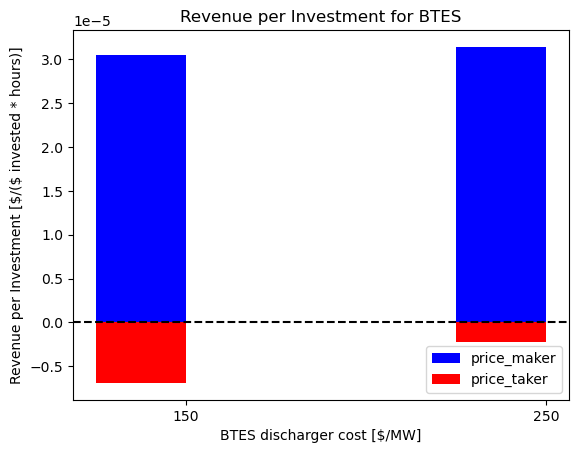

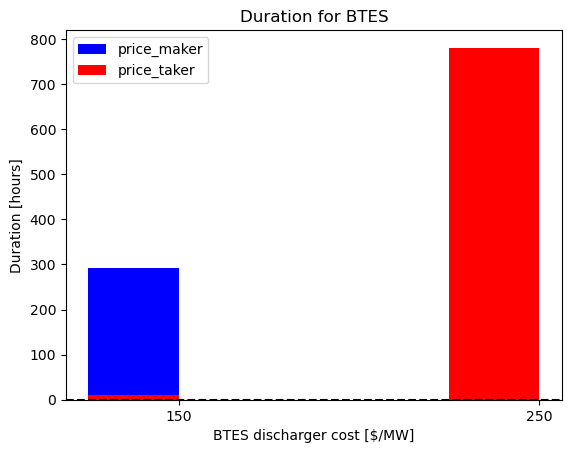

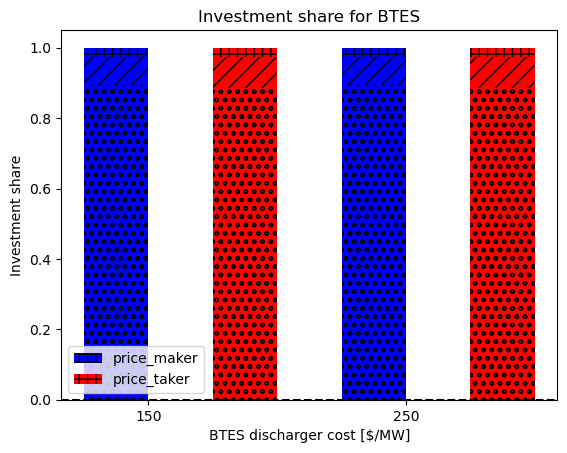

In [8]:
# Plot revenue per investment
plot_bars_maker_taker(prices, rev_per_inv, 'BTES discharger cost [$/MW]', 'Revenue per Investment [$/(\$ invested * hours)]', 'Revenue per Investment for BTES')
# Plot duration
plot_bars_maker_taker(prices, duration, 'BTES discharger cost [$/MW]', 'Duration [hours]', 'Duration for BTES')
# Plot investment share
plot_bars_maker_taker(prices, inv, 'BTES discharger cost [$/MW]', 'Investment share', 'Investment share for BTES')